In [1]:
from pypfopt import EfficientFrontier
from pypfopt import objective_functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from datetime import datetime
from sklearn.decomposition import PCA

In [ ]:
spx = pd.read_csv('spx.csv',index_col='Dates') #S&P 500 index
data = pd.read_csv('msci sector indices.csv',index_col='Dates') # sector indices
asset = pd.read_csv('trading_asset.csv',index_col=0) #trading assets

In [3]:
class AbsorptionRatio:
    
    def __init__(self, data, spx):
        self.data = data #price data
        self.spx = spx #sp500
        self.ar = None #absorption ratio
        self.delta = None #standardized absorption ratio
    
    def absorption_ratio(self, is_returns = False, lookback = 500, halflife = 250, num_pc = 1):
        data = self.data
        if is_returns:
            ret = data
        else:
            ret = np.log(data).diff()[1:]

        ar = []
        for i in range(lookback,len(ret)+1):
            temp_ret = ret[i-lookback:i]
            model = PCA(n_components=num_pc).fit(temp_ret)
            pc = pd.DataFrame(model.transform(temp_ret))
            #variance explained by first n principal components
            pc_var = pc.ewm(halflife=halflife,min_periods=lookback).var().sum().sum()
            #variance in original data
            ret_var = temp_ret.ewm(halflife=halflife,min_periods=lookback).var().sum().sum()
            #absorption ratio
            ar.append(pc_var/ret_var)
            
        ar = pd.DataFrame(ar)
        ar.index = ret.index[lookback-1:]
        ar.columns = ['AR']
        self.ar = ar
        return ar
    
    def delta_ar(self, ar):
        self.delta = ((ar.rolling(15).mean() - ar.rolling(250).mean())/ar.rolling(250).std()).iloc[250:]
        return self.delta
    
    def visualize(self, ar, spx):
        df = ar.copy()
        df = df.join(spx,how='inner')
        df.columns = ['ar','spx']
        df.ar.plot(label='ar', legend=True)
        df.spx.plot(secondary_y=True,label='spx', legend=True)

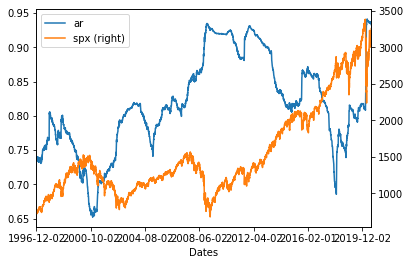

In [4]:
AR = AbsorptionRatio(data,spx)
ar = AR.absorption_ratio(num_pc = 3)
delta = AR.delta_ar(ar)
AR.visualize(ar,spx)

In [20]:
class BackTest:
    def __init__(self, data):
        self.data = data #delta
        self.regime = None
    
    def choose_best_seed(self, df):
        '''
        Return the seed that generates best parameters in hmm
        :param df: data input to hmm
        '''
        max_score = -float('inf')
        for i in range(50):
            model = GaussianHMM(n_components=2, n_iter = 1000, random_state = i)
            model.fit(df)
            temp = model.score(df)
            if temp > max_score:
                best_seed = i
                max_score = temp
        return best_seed
    
    def detect_regime(self, days_to_train=1000, rebalance=100, min_length=60):
        '''
        detect regime using data
        :param days_to_train: days of data used to train model for each time
        :param rebalance: frequency of re-estimate the model
        '''
        data = self.data
        seed = self.choose_best_seed(data.iloc[:days_to_train])
        new_model = GaussianHMM(n_components=2, n_iter = 1000, random_state = seed)
        new_model.fit(data.iloc[:days_to_train])
        regime = new_model.predict(data.iloc[:days_to_train])
        
        flag = False
        for i in range(days_to_train, len(data)):
            if (i - days_to_train + 1) % rebalance == 0:
                seed = self.choose_best_seed(data.iloc[:i])
                new_model = GaussianHMM(n_components=2, n_iter = 1000, random_state = seed)
                new_model.fit(data.iloc[:i])
                #check if regime definations are consistent
                pred_new = new_model.predict(data.iloc[:i])
                if (pred_new == regime).sum() < 0.5 * (i - days_to_train):
                    flag = True
                else:
                    flag = False
            
            #predict states for a path of length days_to_train
            state = new_model.predict(data.iloc[:i+1])[-1]
            
            if flag:
                state = abs(1 - state)

            regime = np.append(regime, state)
        regime = self.regime_filter(regime,min_length)
        regime = pd.DataFrame(regime, index = data.index,columns = ['regime'])
        self.regime = regime
        return regime
    
    def regime_filter(self,regime,min_length):
        '''
        Controls the minimum length of a regime
        :param regime: regime df
        :param min_length: minimum length of a regime
        '''
        for i in range(0,len(regime)-min_length,min_length):
            target = regime[i]
            if np.sum(regime[i:i+min_length]) != target * min_length:
                regime[i:i+min_length] = [target] * min_length
        return regime
    
    
    def regime_switch(self, regime):
        '''
        returns list of starting points of each regime
        :param regime: regime df
        '''
        n = len(regime)
        init_points = [0]
        init_states = [regime.iloc[0].values[0]]
        for i in range(1,n):
            if (regime.iloc[i].values[0] != regime.iloc[i - 1]).values[0]:
                init_points.append(i)
                init_states.append(regime.iloc[i].values[0])
        
        init_points.append(n)
        #return init_points, init_states
        return init_points
    
    def plot_regime_color(self, df):
        '''
        Plot of data versus regime
        :param df: data
        '''
        df = df.join(self.regime, how='inner')
        df.index = [datetime.strptime(date, '%Y-%m-%d') for date in df.index]
        regimelist = self.regime_switch(df[['regime']])
        y_max = df.max().max()
        curr_reg = df['regime'][0]
        df = df.drop('regime',axis=1)

        fig, ax = plt.subplots()
        for i in range(len(regimelist)-1):
            if curr_reg == 0:
                ax.axhspan(0, y_max*1.2, xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
                            facecolor='green', alpha=0.5) 
            else:
                ax.axhspan(0, y_max*1.2, xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
                            facecolor='red', alpha=0.5)
            curr_reg = abs(curr_reg - 1)

        fig.set_size_inches(20,9)   
        for col in df.columns:
            plt.plot(df[col],label=col)
        plt.legend()
        plt.ylabel('value')
        plt.xlabel('Year')
        plt.xlim([df.index[0], df.index[-1]])
        plt.ylim([0, y_max*1.2])
        plt.show()

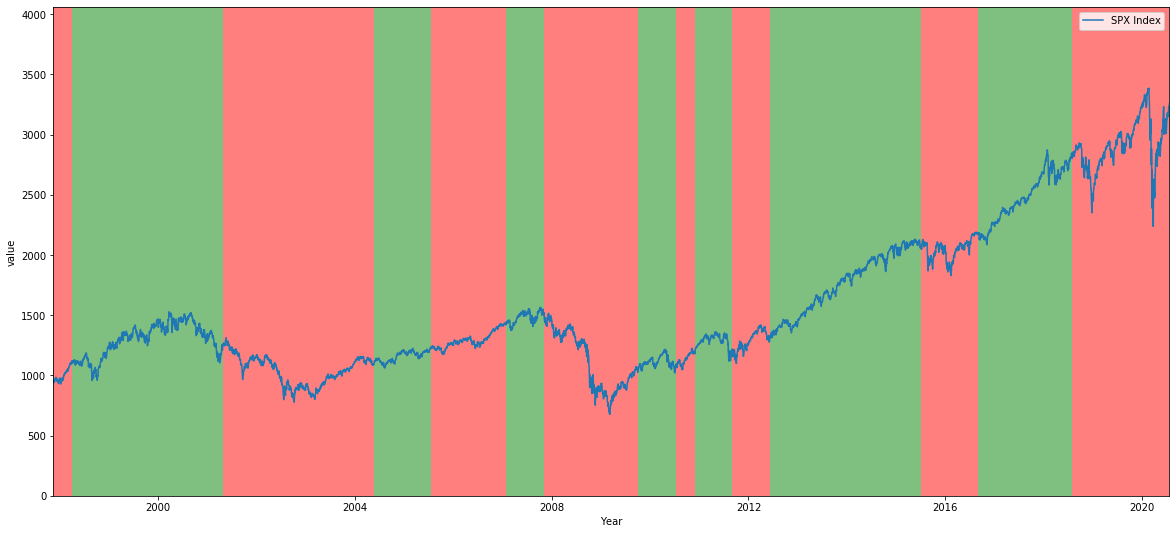

In [23]:
bt = BackTest(delta)
regime = bt.detect_regime(days_to_train = 1500,rebalance=60,min_length=100) #get regime
bt.plot_regime_color(spx)

In [25]:
class Portfolio:
    '''
    Portfolio is a class defining the characteristics of a portfolio
    '''

    def __init__(self, asset_price, tickers):
        '''
        Initialize class attributes
        :param asset_price: dataframe including trading universe and regime
        :param tickers: asset tickers
        '''

        self.tickers = tickers
        self.price = asset_price
        self.ret = None  # daily log return

        self.weights_special = []  # optimum weights for regime-based portfolio
        self.weights_base = []  # optimum weights for base portfolio

        self.date0 = None  # dates for regime 0
        self.date1 = None  # dates for regime 1

        self.mu_special = None  # expected return for special portfolio
        self.S_special = None  # covariance matrix for special portfolio

        self.mu_base = None  # expected return for base portfolio
        self.S_base = None  # expected return for base portfolio

        self.value_special = 0  # special portfolio value
        self.value_base = 0  # base portfolio value

    def initialize_ret_cov(self, n=500):
        '''
        Initialize expected returns and covariance matrices
        :param n: first n days for initializing return and cov
        '''

        self.ret = np.log(self.price.iloc[:, :-1]).diff().dropna()
        state = self.price['regime'][1:]
        df = self.ret[:n]
        # expected returns and covariance matrix for base portfolio
        self.S_base = df.ewm(span=len(df), min_periods=len(df)).cov().dropna() * 252
        self.mu_base = df.ewm(span=len(df), min_periods=len(df)).mean().iloc[-1] * 252
        # expected returns and covariance matrix for special portfolio
        self.date0 = list(state[:n][state == 0].index)
        self.date1 = list(state[:n][state == 1].index)
        if state[n] == 0:
            df = df.loc[self.date0]
        else:
            df = df.loc[self.date1]
        self.S_special = df.ewm(span=len(df), min_periods=len(df)).cov().dropna() * 252
        self.mu_special = df.ewm(span=len(df), min_periods=len(df)).mean().iloc[-1] * 252

    def update_ret_cov(self, state):
        '''
        Update expected returns and covariance matrices for base and special portfolios
        :param state: today's regime: 0 or 1
        '''

        # special portfolio
        if state == 0:
            span = len(self.date0)
            self.mu_special = self.ret.loc[self.date0].ewm(span=span, min_periods=span).mean().iloc[-1] * 252
            self.S_special = self.ret.loc[self.date0].ewm(span=span, min_periods=span).cov().dropna() * 252
        elif state == 1:
            span = len(self.date1)
            self.mu_special = self.ret.loc[self.date1].ewm(span=span, min_periods=span).mean().iloc[-1] * 252
            self.S_special = self.ret.loc[self.date1].ewm(span=span, min_periods=span).cov().dropna() * 252
        # base portfolio
        span = len(self.date0) + len(self.date1)
        date = sorted(self.date0 + self.date1)
        self.mu_base = self.ret.loc[date].ewm(span=span, min_periods=span).mean().iloc[-1] * 252
        self.S_base = self.ret.loc[date].ewm(span=span, min_periods=span).cov().dropna() * 252

    def to_list(self, dic):
        '''
        convert a OrderedDict into a list
        :param dic: ordered dictionary
        '''
        return [dic[i] for i in self.tickers]

    def optimize_weights(self, mu, S, method, state = None, stock_pct = None, target_vol = None, target_ret = None):
        '''
        Compute optimum asset weights given expected returns and covariance matrix
        :param mu: expected return
        :param S: covariance matrix
        :param method：optimizer('max sharpe'/'min variance'/'max return given risk'/'min risk given return')
        :param state: regime number (0/1)
        :param stock_pct:lower limit for stock holdings under low volatility regime for regime-based portfolio
        :param target_vol: target volatility if using method 'max return given risk'
        :param target_ret: target return if using method 'min risk given return'
        '''
        ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.5))
        ef.add_objective(objective_functions.L2_reg, gamma=0.1)
        
        if stock_pct and state == 0:
            ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3]+w[4] >= stock_pct)
        elif stock_pct and state == 1:
            ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3]+w[4] <= 1 - stock_pct)
            
        if method == 'max sharpe':
            ef.max_sharpe(risk_free_rate=0)
        elif method == 'min variance':
            ef.min_volatility()
        elif method == 'min risk given return':
            if state == 1:
                target_ret /= 2
            ef.efficient_return(target_return = target_ret)
        elif method == 'max return given risk':
            if state == 1:
                target_vol /= 2
            ef.efficient_risk(target_volatility = target_vol)
        weights = self.to_list(ef.clean_weights())
        return weights
    

    
    def compute_weights(self, method, n=500, stock_pct = None, target_vol = None, target_ret = None):
        '''
        Choose optimum weights for each day
        :param n: start computing weights after n days
        :param method: optimizer('max sharpe'/'min variance'/'max return given risk'/'min risk given return')
        :param stock_pct:lower limit for stock holdings under low volatility regime for regime-based portfolio
        :param target_vol: target volatility if using method 'max return given risk'
        :param target_ret: target return if using method 'min risk given return'
        '''

        state = self.price['regime'][1:]
        # initialize expected returns and covariance matrix
        self.initialize_ret_cov(n)

        # determine first weights for special portfolio
        special = self.optimize_weights(self.mu_special, self.S_special, state=state[n-1], method=method, 
                                        stock_pct=stock_pct, target_vol=target_vol, target_ret=target_ret)
        self.weights_special.append(special)
        # determine first weights for baseline portfolio
        base = self.optimize_weights(self.mu_base, self.S_base, method=method, 
                                     target_vol=target_vol, target_ret=target_ret)
        self.weights_base.append(base)
  
        for i, t in zip(range(n, len(state)), self.ret.index[n:]):
            # no regime shift
            if state[i] == state[i - 1]:
                self.weights_special.append(special)
                self.weights_base.append(base)
            # regime shift
            else:
                self.update_ret_cov(state=state[i])
                # update weights for special portfolio
                special = self.optimize_weights(self.mu_special, self.S_special, state=state[i], method=method, 
                                                stock_pct=stock_pct, target_vol=target_vol, target_ret=target_ret)
                self.weights_special.append(special)
                # update weights for baseline portfolio
                base = self.optimize_weights(self.mu_base, self.S_base, method=method, 
                                             target_vol=target_vol, target_ret=target_ret)
                self.weights_base.append(base)
                
        date = self.ret.index[n - 1:]
        self.weights_special = pd.DataFrame(self.weights_special, columns=self.tickers, index=date)
        self.weights_base = pd.DataFrame(self.weights_base, columns=self.tickers, index=date)

    def construct_portfolio(self, method, capital=1e6, rebalance=60, n=500, stock_pct = None, target_vol = None, target_ret = None):
        '''
        Compute special/base portfolio value for each day
        :param method: optimizer('max sharpe'/'min variance')
        :param capital: starting capital to invest
        :param rebalance: rebalance frequency in days
        :param n:start computing weights after n days
        :param stock_pct: lower limit for stock holdings under low volatility regime for regime-based portfolio
        :param target_vol: target volatility if using method 'max return given risk'
        :param target_ret: target return if using method 'min risk given return'
        '''

        # compute optimum weights
        self.compute_weights(method=method, n=n, stock_pct=stock_pct, 
                             target_vol=target_vol, target_ret=target_ret)
        # retrieve price and regime data
        price = self.price.loc[self.weights_special.index].drop('regime', axis=1)
        regime = self.price.loc[self.weights_special.index]['regime']
        # portfolio values
        special = []
        base = []
        for i, t in zip(range(len(price)), price.index):
            # when regime shifts, reallocate capital
            if i > 0 and regime.iloc[i] != regime.iloc[i - 1]:
                holdings1 = special[-1] * self.weights_special.loc[t] / price.loc[t]
                holdings2 = base[-1] * self.weights_base.loc[t] / price.loc[t]

            # rebalance the portfolios regularly
            elif i > 0 and i % rebalance == 0:
                holdings1 = special[-1] * self.weights_special.loc[t] / price.loc[t]
                holdings2 = base[-1] * self.weights_base.loc[t] / price.loc[t]

            elif i == 0:
                holdings1 = capital * self.weights_special.loc[t] / price.loc[t]
                holdings2 = capital * self.weights_base.loc[t] / price.loc[t]

            value1 = np.sum(holdings1 * price.loc[t])  # special
            value2 = np.sum(holdings2 * price.loc[t])  # base

            special.append(value1)
            base.append(value2)

        self.value_special = pd.DataFrame(special, columns=['value'], index=price.index)
        self.value_base = pd.DataFrame(base, columns=['value'], index=price.index)


    @staticmethod
    def cal_metric(portfolio):
        '''
        Evaluate portfolio performance
        :param portfolio: dataframe of portfolio value
        :return: annual return, volatility, Sharpe ratio, Maximum Drawdown
        '''

        df = portfolio.copy()
        #df['year'] = [df.index[i].split('/')[2] for i in range(len(df))]
        df['year'] = [df.index[i].year for i in range(len(df))]
        metric = pd.DataFrame()

        # annualized return
        annual_ret = (df.groupby('year').last() - df.groupby('year').first()) / df.groupby('year').first()
        days = df.groupby('year').count()
        annual_ret = (1 + annual_ret) ** (252 / days) - 1
        metric = annual_ret
        metric['days'] = days
        metric.columns = ['annual return', 'days']

        # annualilzed volatility
        df['daily return'] = df['value'].pct_change()
        metric['daily vol'] = df.groupby('year')[['daily return']].std()
        metric['annual vol'] = metric['daily vol'] * np.sqrt(metric['days'])

        # sharpe ratio
        metric['Sharpe'] = metric['annual return'] / metric['annual vol']

        # MDD
        df['cummax'] = df.groupby('year')['value'].cummax()
        df['DD'] = (df['value'] - df['cummax']) / df['cummax']
        metric['MDD'] = df.groupby('year')['DD'].min()

        return metric[['annual return', 'annual vol', 'Sharpe', 'MDD']]

In [27]:
price = asset.join(regime,how='inner')
tickers = asset.columns

pfo = Portfolio(price,tickers)
#construct portoflio using a chosen optimizer
pfo.construct_portfolio(method='min variance', stock_pct = 0.8)

In [28]:
#compare regime-based portfolio and regular portoflio
p1 = pfo.value_special.copy()
p2 = pfo.value_base.copy()
p1.columns = ['special']
p2.columns = ['base']
p = p1.join(p2, how='inner')

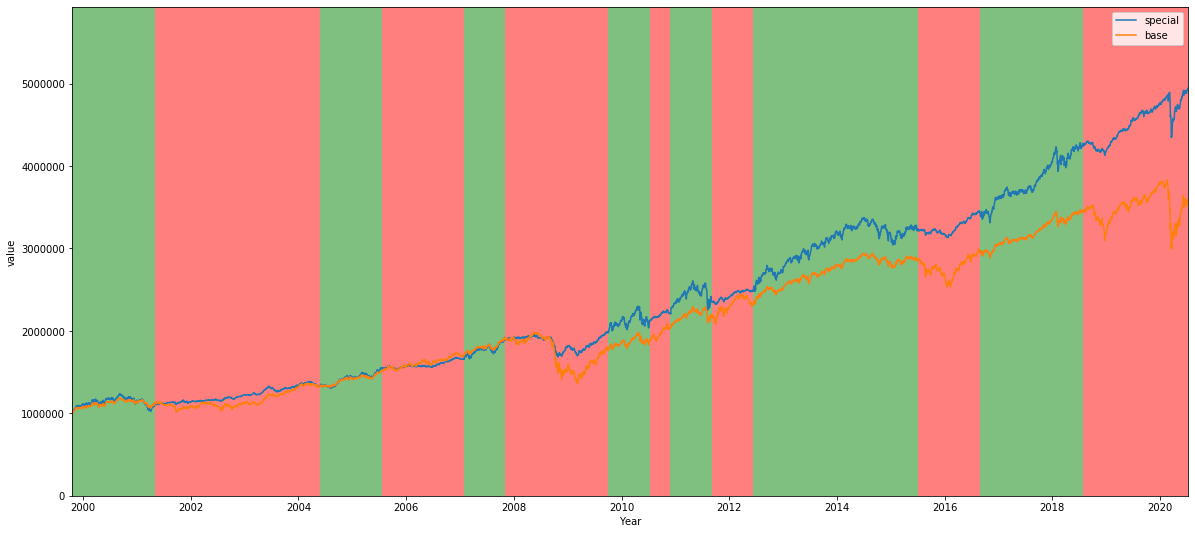

In [29]:
bt.plot_regime_color(p)